In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pyfftw

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils
import plotter

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up bacco: cosmology and power spectrum parameters

In [3]:
idx_LH = 0
idx_LH_str = str(idx_LH)

# order of saved cosmo param files
param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
param_names = ['omega_cold', 'sigma_8', 'h']
    
n_grid = 128
n_grid_orig = 512
box_size = 1000.0

In [4]:
# Quijote LH test data

# still had LH0 in map2map emu dir, preeeetty sure its LH0 cosmo params

dir_mocks = f'/dipc/kstoreyf/muchisimocks/data/cosmolib_rerun'
dir_params = f'/dipc/kstoreyf/muchisimocks/data/cosmolib'

fn_sim = f'{dir_mocks}/LH{idx_LH}/pred_disp.npy'
sim_disp = np.load(fn_sim)

fn_dens = f'{dir_mocks}/LH{idx_LH}/lin_field.npy'
dens_lin = np.load(fn_dens)

In [5]:
fn_params = f'{dir_params}/LH{idx_LH}/cosmo_{idx_LH}.txt'
param_vals = np.loadtxt(fn_params)
param_dict = dict(zip(param_names_all, param_vals))
#del param_dict['seed']
print(param_dict)
cosmo = utils.get_cosmo(param_dict)


2024-07-12 12:04:26,053 bacco.cosmo :    initialization took 0.000 secs


{'omega_cold': 0.2775274936564327, 'sigma_8': 0.7049140324569382, 'h': 0.7241123952301097, 'omega_baryon': 0.049, 'n_s': 0.9624, 'seed': 0.0}


In [6]:
cosmo_params_emu = utils.cosmo_bacco_to_cosmo_baccoemu(cosmo)
print(cosmo_params_emu)

{'sigma8_cold': 0.7049140324569382, 'omega_cold': 0.2775274936564327, 'hubble': 0.7241123952301097, 'ns': 0.9624, 'omega_baryon': 0.049, 'expfactor': 1, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0}


In [7]:
k_min = 0.01
k_max = 1.0
n_bins = 30
log_binning = True
n_threads = 4

deposit_method = 'cic'
interlacing = False
correct_grid = True
deconvolve_grid = True
normalise_grid = True

# defaults from bacco.statistics.compute_power
# unless passed or otherwise denoted
args_power = {
    "ngrid": n_grid,
    "box": box_size,
    #"pos": None,
    "vel": None,
    "mass": None,
    "interlacing": interlacing, #default: None
    "unit_in_Mpc": 1,
    "deposit_method": deposit_method, # default: 'cic',
    "bs_method": None,
    "bs_num_triangles": 10000,
    "bs_k1": 0.01,
    "bs_k2": None,
    "bs_deltak": None,
    "log_binning": log_binning,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid, #default: True,
    "deconvolve_grid": deconvolve_grid, #default: True,
    "normalise_grid": normalise_grid, #default: True,
    "totalmass": None,
    "correct_shotnoise": False,
    "zspace": False,
    "cosmology": cosmo,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "grid1": None,
    "dilution": None,
    "folds": None,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "jack_error": False,
    "n_jack": None
}

# defaults from bacco.statistics.compute_crossspectrum_twogrids
# unless passed or otherwise denoted
args_power_grid = {
    # "grid1": None,
    # "grid2": None,
    "normalise_grid1": normalise_grid, #default: False
    "normalise_grid2": normalise_grid, #default: False
    "deconvolve_grid1": deconvolve_grid, #default: False
    "deconvolve_grid2": deconvolve_grid, #default: False
    "ngrid": n_grid,
    "box": box_size,
    "mass1": None,
    "mass2": None,
    "interlacing": interlacing, #default: True
    "deposit_method": deposit_method, #default: "tsc",
    "log_binning": log_binning,
    "pk_lt": None,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid,
    "zspace": False,
    "cosmology": cosmo,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "folds": 1,
    "totalmass1": None,
    "totalmass2": None,
    "jack_error": False,
    "n_jack": None
}

pknbody_dict = {
    'ngrid': n_grid,
    'min_k': k_min,
    'log_binning': log_binning,
    'log_binning_kmax': k_max,
    'log_binning_nbins': n_bins,
    'interlacing': interlacing,
    'depmethod': deposit_method,
    'correct_grid': correct_grid,
    'folds': 1 #default
}
bacco.configuration.update({'number_of_threads': n_threads})
bacco.configuration.update({'pknbody': pknbody_dict})
bacco.configuration.update({'pk' : {'maxk' : k_max}})
bacco.configuration.update({'scaling' : {'disp_ngrid' : n_grid}})


In [58]:
args_power_grid_deconvolveFalse = args_power_grid.copy()
args_power_grid_deconvolveFalse['deconvolve_grid1'] = False
args_power_grid_deconvolveFalse['deconvolve_grid2'] = False

args_power_grid_hr = args_power_grid.copy()
args_power_grid_hr['ngrid'] = 512

args_power_grid_hr_deconvolveFalse = args_power_grid_hr.copy()
args_power_grid_hr_deconvolveFalse['deconvolve_grid1'] = False
args_power_grid_hr_deconvolveFalse['deconvolve_grid2'] = False

## Make fields

In [6]:

cosmo_params = {
    'neutrino_mass' :  0.0,
    'w0'            : -1.0,
    'wa'            :  0.0,
    'expfactor'     :  1
}

In [7]:
# copied from DataCreationPipeline.py

## Create regular grid and displace particles
print("Generating grid")
grid = bacco.visualization.uniform_grid(npix=n_grid_orig, L=box_size, ndim=3, bounds=False)

print("Adding predicted displacements")
sim_pos = bacco.scaler.add_displacement(None,
                                    sim_disp,
                                    box=box_size,
                                    pos=grid.reshape(-1,3),
                                    vel=None,
                                    vel_factor=0,
                                    verbose=True)[0]

Generating grid


2024-07-09 18:00:24,737 bacco.scaler : Adding displacement field with a vel-factor=0.000000


Adding predicted displacements
bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [8]:
FixedInitialAmplitude = False
seed = int(param_dict['seed'])
sim, disp_field = bacco.utils.create_lpt_simulation(cosmo, box_size, Nmesh=n_grid_orig, Seed=seed,
                                                    FixedInitialAmplitude=FixedInitialAmplitude,InitialPhase=0, 
                                                    expfactor=1, LPT_order=1, order_by_order=None,
                                                    phase_type=1, ngenic_phases=True, return_disp=True, 
                                                    sphere_mode=0)

2024-07-09 18:00:30,140 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
2024-07-09 18:00:30,142 bacco.sims : Initialising simulation Default
2024-07-09 18:00:30,143 bacco.sims : ...done in 0.00113 s
2024-07-09 18:00:30,848 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.442 secs
2024-07-09 18:00:30,850 bacco.cosmo :    created Pk(z=0) tab from k 6.905005284352228e-05 to 100000.0 h/Mpc
2024-07-09 18:00:39,020 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.415 secs
2024-07-09 18:00:39,024 bacco.cosmo :    created Pk(z=0) tab from k 6.905005284352228e-05 to 100000.0 h/Mpc


bacco.lss_scaler : 292 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =4; seed =0 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =0 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table


2024-07-09 18:00:59,620 bacco.scaler : Adding displacement field with a vel-factor=49.066468


bacco.lss_scaler:  Adding LSS displacement: vel_factor=49.066468 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [9]:
damping_scale = 0.7 #k_nyq
interlacing = False

print("Setting up bias model")
bmodel = bacco.BiasModel(sim=sim, linear_delta=dens_lin, ngrid=n_grid_orig, ngrid1=None, 
                            sdm=False, mode="dm",
                            npart_for_fake_sim=n_grid_orig, damping_scale=damping_scale, 
                            bias_model='expansion', deposit_method="cic", 
                            use_displacement_of_nn=False, interlacing=interlacing, 
                            )


2024-07-09 18:01:06,883 bacco.BiasModel : Initialising Bias Model class ...


Setting up bias model


In [10]:
bias_fields = bmodel.bias_terms_lag()

2024-07-09 18:01:09,984 bacco.BiasModel : Computing delta_to_tidal_field with 4 threads...
2024-07-09 18:01:09,986 bacco.BiasModel : fttw plan
2024-07-09 18:01:09,987 bacco.BiasModel : Computing linear field ...
2024-07-09 18:01:09,989 bacco.BiasModel : Memory used: 11.851792384 Gigabytes
2024-07-09 18:01:09,993 bacco.BiasModel : fttw freqs
2024-07-09 18:01:09,994 bacco.BiasModel : tidk freqs
2024-07-09 18:01:20,223 bacco.BiasModel : ifft
2024-07-09 18:02:01,853 bacco.BiasModel : Computing laplacian ...
2024-07-09 18:02:01,856 bacco.BiasModel : Memory used: 16.68544512 Gigabytes
2024-07-09 18:02:04,002 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-07-09 18:02:04,004 bacco.BiasModel : Memory used: 17.222479872 Gigabytes
2024-07-09 18:02:04,275 bacco.BiasModel : Computing delta squared ...
2024-07-09 18:02:04,277 bacco.BiasModel : Memory used: 17.759207424 Gigabytes
2024-07-09 18:02:05,107 bacco.BiasModel : Computing tidal component G2 with the given tidal field
20

In [68]:
bias_terms_eul_hr=[]
for ii in range(0,len(bias_fields)):
    bias_terms_hr = bacco.statistics.compute_mesh(ngrid=n_grid_orig, box=box_size, pos=sim_pos, 
                                mass = (bias_fields[ii]).flatten(), deposit_method='cic', 
                                interlacing=interlacing)
    bias_terms_eul_hr.append(bias_terms_hr)
bias_terms_eul_hr = np.array(np.squeeze(bias_terms_eul_hr))

2024-07-09 18:37:14,461 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-09 18:37:14,462 bacco.statistics : starting deposit 1
2024-07-09 18:37:19,019 bacco.statistics :  mesh done in 4.56 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-09 18:37:19,994 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-09 18:37:19,995 bacco.statistics : starting deposit 1
2024-07-09 18:37:24,564 bacco.statistics :  mesh done in 4.57 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-09 18:37:25,480 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-09 18:37:25,481 bacco.statistics : starting deposit 1
2024-07-09 18:37:29,922 bacco.statistics :  mesh done in 4.44 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-09 18:37:30,849 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-09 18:37:30,850 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb


2024-07-09 18:37:35,343 bacco.statistics :  mesh done in 4.49 s


bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-09 18:37:36,242 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-09 18:37:36,243 bacco.statistics : starting deposit 1
2024-07-09 18:37:40,811 bacco.statistics :  mesh done in 4.57 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)
[[[[ 4.65046972e-01  1.66364104e-01  1.99700043e-01 ...  1.25449204e+00
     8.59896779e-01  1.31075525e+00]
   [ 3.22540194e-01  5.26725501e-02  5.24317622e-01 ...  1.67249954e+00
     1.35853982e+00  9.36198890e-01]
   [ 5.61226249e-01  4.05593328e-02  4.09909159e-01 ...  9.52745140e-01
     1.42837894e+00  6.87089860e-01]
   ...
   [ 1.31477690e+00  1.24927258e+00  1.31813717e+00 ...  3.87719005e-01
     2.09364325e-01  3.19570065e-01]
   [ 6.77930593e-01  7.62286782e-01  8.91062856e-01 ...  5.38908958e-01
     2.96786159e-01  6.75770640e-01]
   [ 8.56859267e-01  3.09524983e-01  5.48562884e-01 ...  7.34820604e-01
     1.28242224e-01  7.67709672e-01]]

  [[ 2.03325891e+00  3.04968864e-01  2.94715166e-01 ...  4.76340503e-01
     1.41698837e-01  1.72101676e+00]
   [ 6.70869052e

In [69]:
bias_terms_eul_hr.shape

(5, 512, 512, 512)

In [111]:
def downsample_field(bias_terms_eul_pred, box_size, ngrid_target):
    # updated to squeeze out the extra dim and then alter where needed
    bias_terms_eul_pred = np.squeeze(bias_terms_eul_pred)
    ngrid = bias_terms_eul_pred.shape[-1]
    k_nyq = np.pi/box_size*ngrid_target
    kmesh = bacco.visualization.np_get_kmesh( (ngrid, ngrid, ngrid), box_size, real=True)
    mask = (kmesh[:,:,:,0]<=k_nyq) & (kmesh[:,:,:,1]<=k_nyq) & (kmesh[:,:,:,2]<=k_nyq) & (kmesh[:,:,:,0]>-k_nyq) & (kmesh[:,:,:,1]>-k_nyq) & (kmesh[:,:,:,2]>-k_nyq)
    bias_terms_eul_pred_kcut=[]
    assert ngrid_target%2==0, "ngrid_target must be even!"
    for fid in range(5):
        field = bias_terms_eul_pred[fid]
        #field = bias_terms_eul_pred[fid][0]
        deltak = pyfftw.builders.rfftn(field, auto_align_input=False, auto_contiguous=False, avoid_copy=True)
        deltakcut = deltak()[mask]
        deltakcut= deltakcut.reshape(ngrid_target, ngrid_target, int(ngrid_target/2)+1)
        delta = pyfftw.builders.irfftn(deltakcut, axes=(0,1,2))()
        bias_terms_eul_pred_kcut.append(delta)
    bias_terms_eul_pred_kcut = np.array(bias_terms_eul_pred_kcut)
    return bias_terms_eul_pred_kcut

In [112]:
ngrid_target = 128
bias_terms_eul = downsample_field(bias_terms_eul_hr, box_size, ngrid_target)

In [19]:
bias_vector = [0.,0.,0.,0.]
if n_grid_orig is None:
    n_grid_orig = bias_terms_eul_hr.shape[-1]
print(f"n_grid_orig = {n_grid_orig}")
tracer_field_hr = utils.utils.utils.utils.get_tracer_field(bias_terms_eul_hr, bias_vector, n_grid_norm=n_grid_orig)
tracer_field_hr = np.squeeze(tracer_field_hr)
print(tracer_field_hr.shape)

n_grid_orig = 512
(512, 512, 512)


In [20]:
if n_grid_orig is None:
    n_grid_orig = bias_terms_eul.shape[-1]
print(f"n_grid_orig = {n_grid_orig}")
tracer_field = utils.get_tracer_field(bias_terms_eul, bias_vector, n_grid_norm=n_grid_orig)
print(tracer_field.shape)

n_grid_orig = 512
(128, 128, 128)


## Compute p(k)'s

In [21]:

pk_obj_mesh_fromdisp_tracer = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field,
                    grid2=tracer_field,
                    **args_power_grid)

2024-07-09 18:04:44,493 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-07-09 18:04:44,932 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.436 secs
2024-07-09 18:04:44,936 bacco.cosmo :    created Pk(z=0) tab from k 6.905005284352228e-05 to 100000.0 h/Mpc
2024-07-09 18:04:44,944 bacco.cosmo :    computed halofit at z=0.00 for 'Default' in 0.004 secs
2024-07-09 18:04:45,068 bacco.statistics :  ...done in 0.575 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.006098 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.048767 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000157 secs
bacco.power : Deallocating arrays


In [22]:
pk_obj_mesh_fromdisp_tracer_hr = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_hr,
                    grid2=tracer_field_hr,
                    **args_power_grid_hr)

2024-07-09 18:04:46,601 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.008087 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.805050 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000155 secs
bacco.power : Deallocating arrays


2024-07-09 18:04:52,736 bacco.statistics :  ...done in 6.14 s


In [23]:
pk_obj_mesh_fromdisp_tracer_deconvolveFalse = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field,
                    grid2=tracer_field,
                    **args_power_grid_deconvolveFalse)

2024-07-09 18:04:54,278 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-07-09 18:04:54,378 bacco.statistics :  ...done in 0.1 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.009755 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043344 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000263 secs
bacco.power : Deallocating arrays


In [24]:
pk_obj_mesh_fromdisp_tracer_hr_deconvolveFalse = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_hr,
                    grid2=tracer_field_hr,
                    **args_power_grid_hr_deconvolveFalse)

2024-07-09 18:04:55,892 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.987663 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.783755 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000146 secs
bacco.power : Deallocating arrays


2024-07-09 18:05:01,941 bacco.statistics :  ...done in 6.05 s


## Emu p(k)

In [9]:
# Careful, these are diff than quijote, so order of running this nb matters
param_names_2_emu_param_names = {'sigma_8': 'sigma8_cold',
                                 'omega_cold': 'omega_cold',
                                 'h': 'hubble',
                                 'n_s': 'ns',
                                 'omega_baryon': 'omega_baryon'
                                 }

In [10]:
emu_mpk_ext, emu_bounds_mpk_ext, emu_param_names_mpk_ext = utils.load_emu(emu_name='mpk_extended')
emu_bounds_dict_mpk_ext = dict(zip(emu_param_names_mpk_ext, emu_bounds_mpk_ext))

Loading sigma8 emulator...
HIIII
Sigma8 emulator loaded in memory.
Loading linear emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using v

Linear emulator loaded in memory.
Loading no-wiggles emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


No-wiggles emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [23]:
kk = pk_obj_mesh_fromdisp_tracer_hr['k']
_, pk_emu, = emu_mpk_ext.get_nonlinear_pk(k=kk, cold=True, **cosmo_params_emu)

NameError: name 'pk_obj_mesh_fromdisp_tracer_hr' is not defined

## Plot

/tmp/ipykernel_229281/2949311584.py:76: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
/tmp/ipykernel_229281/2949311584.py:77: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])


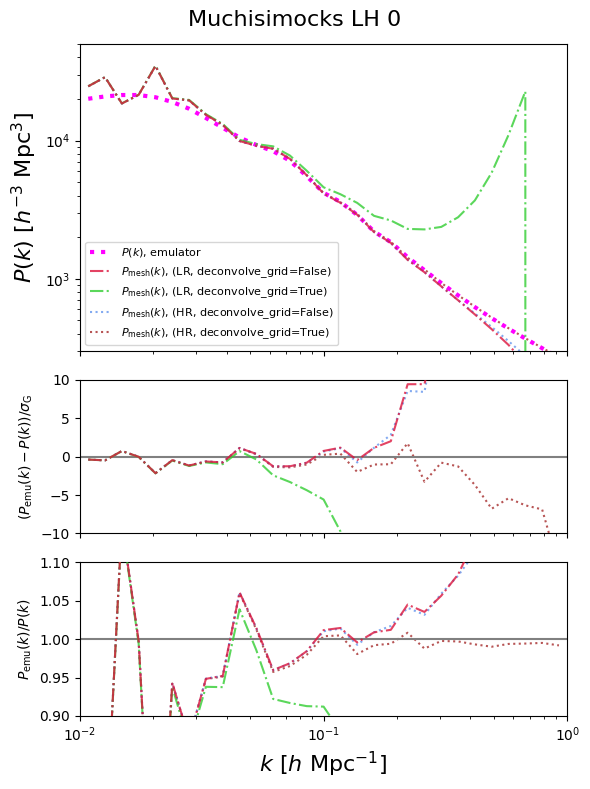

In [55]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

# labels = [r'$P_\text{part}(k)$ (deconvolve_grid=False)', 
#           #r'$P_\text{mesh}(k)$ (deconvolve_grid=False)', 
#           r'$P_\text{part}(k)$ (deconvolve_grid=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True,'+'\n interlacing=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True,'+'\n correct_grid=False)',
#           r'$P_\text{mesh}(k)$ (deconvolve_grid=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True),'+'\n from Quijote snapshot',
#           ]
labels = [ #r'$P_\text{mesh}(k)$, from disp (HR, deconvolve_grid=False)',
          #r'$P_\text{mesh}(k)$, from disp (HR, deconvolve_grid=True)',
          r'$P_\text{mesh}(k)$, (LR, deconvolve_grid=False)',
          r'$P_\text{mesh}(k)$, (LR, deconvolve_grid=True)',
          r'$P_\text{mesh}(k)$, (HR, deconvolve_grid=False)',
          r'$P_\text{mesh}(k)$, (HR, deconvolve_grid=True)',
        #   r'$P_\text{mesh}(k)$ (LR, deconvolve_grid=False)',
        #   r'$P_\text{mesh}(k)$ (LR, deconvolve_grid=True)',
        #   #r'$P_\text{mesh}(k)$ (deconvolve_grid=True, correct_grid=True)',
        #   r'$P_\text{mesh}(k)$ (HR, deconvolve_grid=False)',
        #   r'$P_\text{mesh}(k)$ (HR, deconvolve_grid=True)'
          ]
colors = ['crimson', 'limegreen', 'cornflowerblue', 'brown', 'orange', 'darkblue', 'purple', 'grey']
lss = ['-.', '-.', ':', ':', '--', '--', '-', '-']
# pk_objs = [pk_obj_particles_nodeconv,
#            pk_obj_particles,
#            pk_obj_particles_interlacing,
#            pk_obj_particles_nocorrectgrid,
#            pk_obj_mesh, 
#            #pk_obj_particles_deconv_Mpcperh, 
#            #pk_obj_pos_mesh_deconv, 
#            pk_obj_snap,
#            ]
pk_objs = [#pk_obj_mesh_fromdisp_hr_deconvolveFalse,
           #pk_obj_mesh_fromdisp_hr,
           pk_obj_mesh_fromdisp_tracer_deconvolveFalse,
           pk_obj_mesh_fromdisp_tracer,
           pk_obj_mesh_fromdisp_tracer_hr_deconvolveFalse,
           pk_obj_mesh_fromdisp_tracer_hr,
        #    pk_obj_mesh_deconvolveFalse,
        #    pk_obj_mesh,
        #    #pk_obj_mesh_correctgridTrue,
        #    pk_obj_mesh_hr_deconvolveFalse,
        #    pk_obj_mesh_hr
           ]
zorders = list(range(len(pk_objs),0,-1))
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

# ks.append(k_quijote)
# pks.append(pk_quijote)
# errs.append(err_quijote)
# #errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
# labels.append(r'$P(k)$, Quijote measured')
# colors.append('grey')
# lss.append('-')
# zorders.append(0)

plt.suptitle(f'Muchisimocks LH {idx_LH_str}', fontsize=16)

ax.loglog(kk, pk_emu, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=3)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    if len(pk_emu)!=len(pks[i]):
        pk_interp = np.interp(kk, ks[i], pks[i])
        err_interp = np.interp(kk, ks[i], errs[i])
        ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
        ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    else:
        ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
        ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])


ax1.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/\sigma_\text{G}$')
ax2.set_ylabel(r'$P_\text{emu}(k)/P(k)$')
ax.set_xlim(1e-2, 1)
ax.set_ylim(3e2, 5e4)

ax1.set_ylim(-10, 10)
ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=8, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

## Try field-level deconvolution

In [57]:
import bacco.probabilistic_bias as pb

Checked that deconvolving each of the bias fields and then summing into a tracer field gives same result as deconvolving the tracer field directly! Including when bias vector is not all zeros (checked b=[1,0,0,0] case). So we could deconvolve the bias fields and save the deconvolved version.

In [89]:
# Have to do this in a loop, can't just pass bias_terms_eul_hr to the pb function - maybe could rewrite it, but rn no 
bias_terms_eul_hr_deconvolved = []
for i, bias_term in enumerate(bias_terms_eul_hr):
    bias_term_deconvolved = pb.convolve_linear_interpolation_kernel(bias_term, 
                                                                    npix=n_grid_orig, mode="deconvolve")
    bias_terms_eul_hr_deconvolved.append(bias_term_deconvolved)
bias_terms_eul_hr_deconvolved = np.array(bias_terms_eul_hr_deconvolved)
bias_terms_eul_hr_deconvolved.shape

(5, 512, 512, 512)

In [93]:
# Have to do this in a loop, can't just pass bias_terms_eul_hr to the pb function - maybe could rewrite it, but rn no 
bias_terms_eul_deconvolved = []
for i, bias_term in enumerate(bias_terms_eul):
    bias_term_deconvolved = pb.convolve_linear_interpolation_kernel(bias_term, 
                                                                    npix=n_grid_orig, mode="deconvolve")
    bias_terms_eul_deconvolved.append(bias_term_deconvolved)
bias_terms_eul_deconvolved = np.array(bias_terms_eul_deconvolved)
bias_terms_eul_deconvolved.shape

(5, 128, 128, 128)

In [90]:
tracer_field_hr_deconvolved = utils.get_tracer_field(bias_terms_eul_hr_deconvolved, bias_vector, n_grid_norm=n_grid_orig)

In [94]:
tracer_field_deconvolved = utils.get_tracer_field(bias_terms_eul_deconvolved, bias_vector, n_grid_norm=n_grid_orig)

In [99]:
bias_terms_eul_hr_deconvolved.shape

(5, 512, 512, 512)

In [113]:
ngrid_target = 128
bias_terms_eul_fromhrdeconvolved = downsample_field(bias_terms_eul_hr_deconvolved, box_size, ngrid_target)

In [114]:
tracer_field_fromhrdeconvolved = utils.get_tracer_field(bias_terms_eul_fromhrdeconvolved, bias_vector, n_grid_norm=n_grid_orig)

-1.4575713133034672e-06 1.4508998989225246e-05
-1.4575713133034672e-06 1.4508998989225246e-05


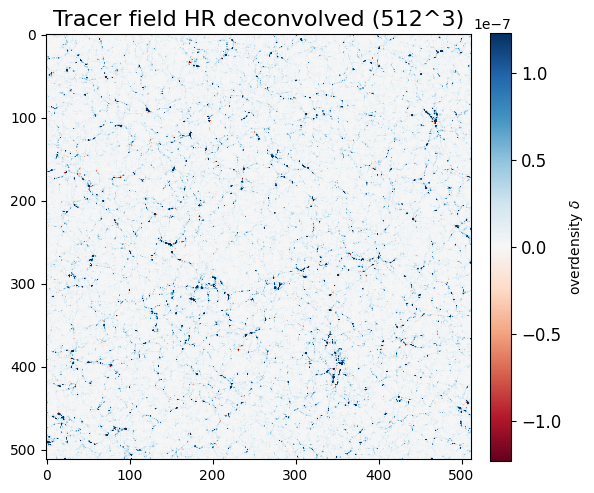

In [91]:
plotter.plot_overdensity_field(tracer_field_hr_deconvolved, title=r'Tracer field HR deconvolved (512^3)',
                               #vmax=0.1
                               )

-2.1424585630773332e-06 6.843647584940654e-06
-2.1424585630773332e-06 6.843647584940654e-06


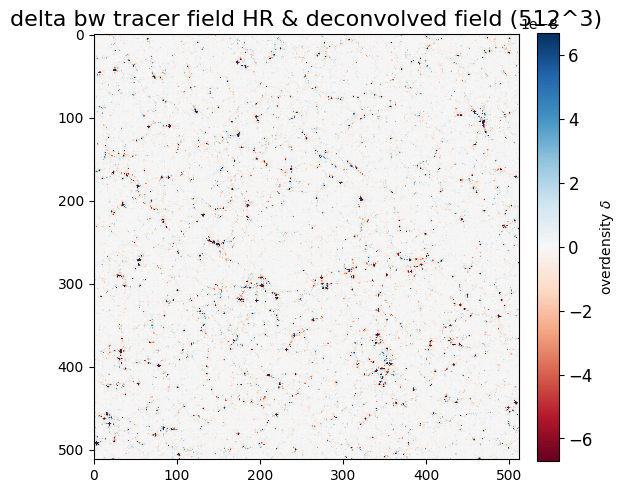

In [92]:
plotter.plot_overdensity_field(tracer_field_hr_deconvolved-tracer_field_hr, 
                               title=r'delta bw tracer field HR & deconvolved field (512^3)',
                               #vmax=0.1
                               )

In [95]:
pk_obj_mesh_fromdisp_tracer_hr_fielddeconvolved = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_hr_deconvolved,
                    grid2=tracer_field_hr_deconvolved,
                    **args_power_grid_hr_deconvolveFalse)

2024-07-09 19:15:46,225 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.114194 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.774032 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000148 secs
bacco.power : Deallocating arrays


2024-07-09 19:15:55,822 bacco.statistics :  ...done in 9.6 s


In [96]:
pk_obj_mesh_fromdisp_tracer_fielddeconvolved = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_deconvolved,
                    grid2=tracer_field_deconvolved,
                    **args_power_grid_deconvolveFalse)

2024-07-09 19:15:57,305 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-07-09 19:15:57,414 bacco.statistics :  ...done in 0.109 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.010691 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.044561 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000285 secs
bacco.power : Deallocating arrays


In [115]:
pk_obj_mesh_fromdisp_tracer_fromhrdeconvolved = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_fromhrdeconvolved,
                    grid2=tracer_field_fromhrdeconvolved,
                    **args_power_grid_deconvolveFalse)

2024-07-09 19:26:01,784 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-07-09 19:26:01,888 bacco.statistics :  ...done in 0.104 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.027780 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.044259 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000142 secs
bacco.power : Deallocating arrays


In [117]:
pk_obj_mesh_fromdisp_tracer_fromhrdeconvolved['pk']

array([24705.46494758, 28757.73279165, 18546.43028629, 21423.97727027,
       34695.96650419, 20178.20937091, 19546.9102048 , 15375.93416172,
       13001.91679315,  9935.600054  ,  9178.30131923,  8746.90924262,
        7394.04419036,  5627.87325459,  4164.95293083,  3576.9224826 ,
        2941.98626996,  2212.63593615,  1860.04700652,  1412.83815183,
        1163.52754177,   934.94939305,   758.94952395,   616.43186799,
         501.88362252,   405.99006205,   316.59611298,     0.        ,
           0.        ,     0.        ])

In [118]:
pk_obj_mesh_fromdisp_tracer_fielddeconvolved['pk']

array([24705.46618721, 28757.77154132, 18546.42941908, 21423.97698639,
       34695.96314447, 20178.20662781, 19546.908774  , 15375.93358568,
       13001.91480163,  9935.59845288,  9178.29983982,  8746.90787314,
        7394.04303923,  5627.87235318,  4164.95219632,  3576.92178936,
        2941.98570711,  2212.63551902,  1860.04664784,  1412.83789325,
        1163.52732116,   934.94921264,   758.94937519,   616.43174794,
         501.88352256,   405.9899843 ,   316.59605568,     0.        ,
           0.        ,     0.        ])

/tmp/ipykernel_229281/459357789.py:72: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
/tmp/ipykernel_229281/459357789.py:73: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


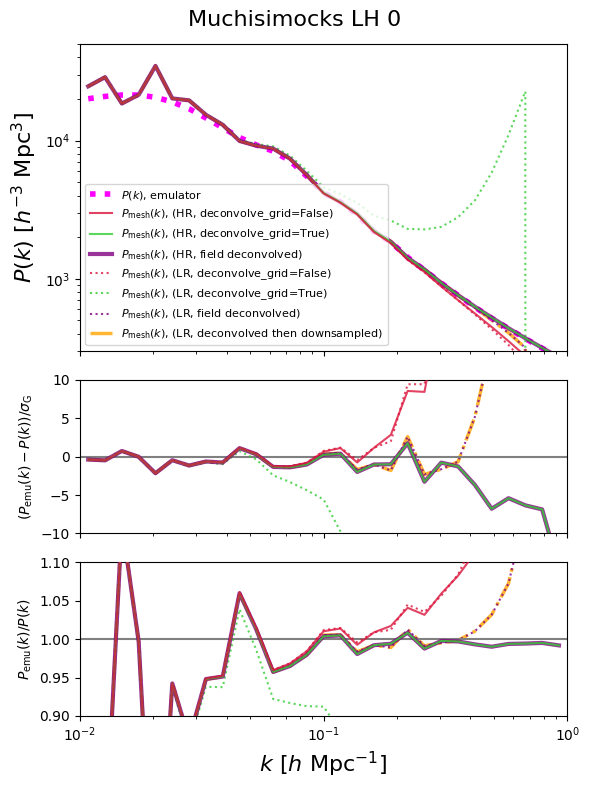

In [138]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

# labels = [r'$P_\text{part}(k)$ (deconvolve_grid=False)', 
#           #r'$P_\text{mesh}(k)$ (deconvolve_grid=False)', 
#           r'$P_\text{part}(k)$ (deconvolve_grid=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True,'+'\n interlacing=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True,'+'\n correct_grid=False)',
#           r'$P_\text{mesh}(k)$ (deconvolve_grid=True)',
#           r'$P_\text{part}(k)$ (deconvolve_grid=True),'+'\n from Quijote snapshot',
#           ]
labels = [
          r'$P_\text{mesh}(k)$, (HR, deconvolve_grid=False)',
          r'$P_\text{mesh}(k)$, (HR, deconvolve_grid=True)',
          r'$P_\text{mesh}(k)$, (HR, field deconvolved)',          
          r'$P_\text{mesh}(k)$, (LR, deconvolve_grid=False)',
          r'$P_\text{mesh}(k)$, (LR, deconvolve_grid=True)',
          r'$P_\text{mesh}(k)$, (LR, field deconvolved)',
          r'$P_\text{mesh}(k)$, (LR, deconvolved then downsampled)',
          ]
colors = ['crimson', 'limegreen', 'purple', 
          'crimson', 'limegreen', 'purple', 
          'orange']
lss = ['-', '-', '-',
       ':', ':', ':', '-.']
lws = [1.5, 1.5, 3,
       1.5, 1.5, 1.5, 2.5]
# lws = [2, 2, 1,
#        2, 2, 2, 1]
pk_objs = [pk_obj_mesh_fromdisp_tracer_hr_deconvolveFalse,
           pk_obj_mesh_fromdisp_tracer_hr,
           pk_obj_mesh_fromdisp_tracer_hr_fielddeconvolved,
           pk_obj_mesh_fromdisp_tracer_deconvolveFalse,
           pk_obj_mesh_fromdisp_tracer,
           pk_obj_mesh_fromdisp_tracer_fielddeconvolved,
           pk_obj_mesh_fromdisp_tracer_fromhrdeconvolved,
        #    pk_obj_mesh_deconvolveFalse,
        #    pk_obj_mesh,
        #    #pk_obj_mesh_correctgridTrue,
        #    pk_obj_mesh_hr_deconvolveFalse,
        #    pk_obj_mesh_hr
           ]
zorders = list(range(len(pk_objs),0,-1))
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

# ks.append(k_quijote)
# pks.append(pk_quijote)
# errs.append(err_quijote)
# #errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
# labels.append(r'$P(k)$, Quijote measured')
# colors.append('grey')
# lss.append('-')
# zorders.append(0)

plt.suptitle(f'Muchisimocks LH {idx_LH_str}', fontsize=16)

ax.loglog(kk, pk_emu, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=4)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    if len(pk_emu)!=len(pks[i]):
        pk_interp = np.interp(kk, ks[i], pks[i])
        err_interp = np.interp(kk, ks[i], errs[i])
        ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    else:
        ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


ax1.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/\sigma_\text{G}$')
ax2.set_ylabel(r'$P_\text{emu}(k)/P(k)$')
ax.set_xlim(1e-2, 1)
ax.set_ylim(3e2, 5e4)

ax1.set_ylim(-10, 10)
ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=8, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

## Check deconvolved lib

In [11]:
idx_LH = 0
idx_LH_str = str(idx_LH)

# order of saved cosmo param files
param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
    
n_grid = 128
n_grid_orig = 512
box_size = 1000.0

In [12]:
# Quijote LH test data

# still had LH0 in map2map emu dir, preeeetty sure its LH0 cosmo params

tag_lib = ''
dir_lib = f'/cosmos_storage/cosmosims/muchisimocks_lib{tag_lib}'
dir_params = f'/dipc/kstoreyf/muchisimocks/data/cosmolib'

In [13]:
fn_params = f'{dir_params}/LH{idx_LH}/cosmo_{idx_LH}.txt'
param_vals = np.loadtxt(fn_params)
param_dict = dict(zip(param_names_all, param_vals))
#del param_dict['seed']
print(param_dict)
cosmo = utils.get_cosmo(param_dict)


2024-07-12 12:05:01,214 bacco.cosmo :    initialization took 0.000 secs


{'omega_cold': 0.2775274936564327, 'sigma_8': 0.7049140324569382, 'h': 0.7241123952301097, 'omega_baryon': 0.049, 'n_s': 0.9624, 'seed': 0.0}


In [14]:
tag_fields = ''
fn_fields = f'{dir_lib}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
bias_terms_eul_lib_nodeconv = np.load(fn_fields)
print(bias_terms_eul_lib_nodeconv.shape)
print(bias_terms_eul_lib_nodeconv.dtype)

FileNotFoundError: [Errno 2] No such file or directory: '/cosmos_storage/cosmosims/muchisimocks_lib/LH0/bias_fields_eul_0.npy'

In [ ]:

tag_fields = '_deconvolved'
fn_fields = f'{dir_lib}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
bias_terms_eul_lib = np.load(fn_fields)
print(bias_terms_eul_lib.shape)

tag_fields_zspace = '_zspace_deconvolved'
fn_fields_zspace = f'{dir_lib}/LH{idx_LH}/bias_fields_eul{tag_fields_zspace}_{idx_LH}.npy'
bias_terms_eul_lib_zspace = np.load(fn_fields_zspace)
print(bias_terms_eul_lib_zspace.shape)

bias_vector = [0.,0.,0.,0.]
tracer_field_lib = utils.get_tracer_field(bias_terms_eul_lib, bias_vector, n_grid_norm=n_grid_orig)
tracer_field_lib_zspace = utils.get_tracer_field(bias_terms_eul_lib_zspace, bias_vector, n_grid_norm=n_grid_orig)

(5, 128, 128, 128)
(5, 128, 128, 128)


In [ ]:
bias_terms_eul_lib.dtype, bias_terms_eul_lib_zspace.dtype

(dtype('float64'), dtype('float64'))

In [ ]:
pk_obj_lib = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_lib,
                    grid2=tracer_field_lib,
                    **args_power_grid_deconvolveFalse)

2024-07-11 17:06:54,285 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-07-11 17:06:54,411 bacco.statistics :  ...done in 0.126 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.009613 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043207 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000386 secs
bacco.power : Deallocating arrays


In [ ]:
pk_obj_lib_zspace = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_lib_zspace,
                    grid2=tracer_field_lib_zspace,
                    **args_power_grid_deconvolveFalse)

2024-07-11 17:06:55,833 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-07-11 17:06:55,992 bacco.statistics :  ...done in 0.159 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.042101 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.044871 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000390 secs
bacco.power : Deallocating arrays


In [ ]:
args_power_grid_deconvolveFalse_zspace = args_power_grid_deconvolveFalse.copy()
args_power_grid_deconvolveFalse_zspace['zspace'] = True

In [ ]:
pk_obj_lib_tozspace = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_lib,
                    grid2=tracer_field_lib,
                    **args_power_grid_deconvolveFalse_zspace)

2024-07-11 17:22:46,436 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-07-11 17:22:46,565 bacco.statistics :  ...done in 0.129 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013139 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.044580 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000393 secs
bacco.power : Deallocating arrays


In [ ]:
kk = pk_obj_lib['k']
_, pk_emu, = emu_mpk_ext.get_nonlinear_pk(k=kk, cold=True, **cosmo_params_emu)

In [ ]:
pk_nlz = cosmo.get_nlzpowerspec(kk, l=0, cold=True, scale=True, bias=1.0)

2024-07-11 17:30:49,353 bacco.cosmo :    computed halofit at z=0.00 for 'Default' in 0.006 secs


/tmp/ipykernel_370520/1591416694.py:54: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
/tmp/ipykernel_370520/1591416694.py:55: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


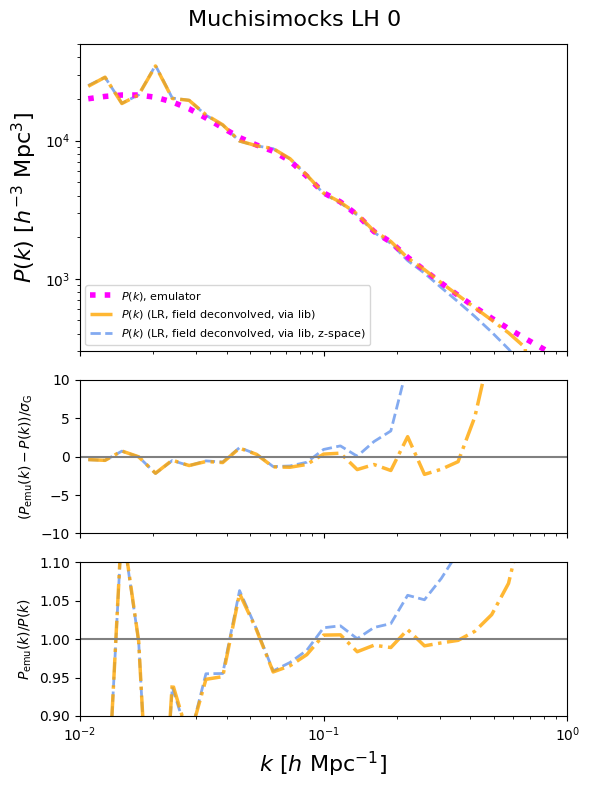

In [ ]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

labels = [
          r'$P(k)$ (LR, field deconvolved, via lib)',
          r'$P(k)$ (LR, field deconvolved, via lib, z-space)',
          r'$P(k)$ (LR, field deconvolved, via lib, p(k) in z-space)',
          ]
colors = ['orange', 'cornflowerblue', 'green']
lss = ['-.', '--', '--']
lws = [2.5, 2, 1.5]
# lws = [2, 2, 1,
#        2, 2, 2, 1]
pk_objs = [pk_obj_lib,
           pk_obj_lib_zspace,
           #pk_obj_lib_tozspace,
        #    pk_obj_mesh_deconvolveFalse,
        #    pk_obj_mesh,
        #    #pk_obj_mesh_correctgridTrue,
        #    pk_obj_mesh_hr_deconvolveFalse,
        #    pk_obj_mesh_hr
           ]
zorders = list(range(len(pk_objs),0,-1))
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

# ks.append(kk)
# pks.append(pk_nlz)
# errs.append(None)
# #errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
# labels.append(r'$P(k)$ NLz')
# colors.append('grey')
# lss.append('-')
# lws.append(1)
# zorders.append(0)

plt.suptitle(f'Muchisimocks LH {idx_LH_str}', fontsize=16)

ax.loglog(kk, pk_emu, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=4)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    if len(pk_emu)!=len(pks[i]):
        pk_interp = np.interp(kk, ks[i], pks[i])
        err_interp = np.interp(kk, ks[i], errs[i])
        ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    else:
        if errs[i] is not None:
            ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


ax1.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/\sigma_\text{G}$')
ax2.set_ylabel(r'$P_\text{emu}(k)/P(k)$')
ax.set_xlim(1e-2, 1)
ax.set_ylim(3e2, 5e4)

ax1.set_ylim(-10, 10)
ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=8, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

In [15]:
plotter.plot_overdensity_field(tracer_field_lib, title=r'Tracer field LR deconvolved (128^3)',
                               )

NameError: name 'tracer_field_lib' is not defined

In [ ]:
plotter.plot_overdensity_field(tracer_field_lib_zspace, title=r'Tracer field LR deconvolved, z-space (128^3)',
                               )

### LH3

In [96]:
idx_LH = 3
idx_LH_str = str(idx_LH)

# order of saved cosmo param files
param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
    
n_grid = 128
n_grid_orig = 512
box_size = 1000.0

In [97]:
# Quijote LH test data

# still had LH0 in map2map emu dir, preeeetty sure its LH0 cosmo params

tag_lib = ''
dir_lib = f'/cosmos_storage/cosmosims/muchisimocks_lib{tag_lib}'
dir_params = f'/dipc/kstoreyf/muchisimocks/data/cosmolib'

In [110]:
fn_params = f'{dir_params}/LH{idx_LH}/cosmo_{idx_LH}.txt'
param_vals = np.loadtxt(fn_params)
param_dict = dict(zip(param_names_all, param_vals))
#del param_dict['seed']
print(param_dict)
cosmo = utils.get_cosmo(param_dict)
cosmo_params_emu = utils.cosmo_bacco_to_cosmo_baccoemu(cosmo)
print(cosmo.pars)
print(cosmo_params_emu)


{'omega_cold': 0.3132348335406776, 'sigma_8': 0.8650479139061382, 'h': 0.6390886264194283, 'omega_baryon': 0.049, 'n_s': 0.9624, 'seed': 3.0}
{'hubble': 0.6390886264194283, 'sigma8': 0.8650479139061382, 'A_s': None, 'omega_baryon': 0.049, 'omega_cdm': 0.2642348335406776, 'w0': -1.0, 'wa': 0.0, 'ns': 0.9624, 'tau': 0.0561, 'approx_nu': False, 'num_massive_neutrinos': 0, 'neutrino_mass': 0.0, 'Neffective': 3.046, 'DeltaNeff': 3.046, 'GammaNu': 0.71611, 'omega_neutrino': 0.0, 'omega_matter': 0.3132348335406776, 'omega_cold': 0.3132348335406776, 'photon_temperature': 2.7255, 'omega_photons': 0.0, 'omega_rad': 0.0, 'omega_de': 0.6867651664593224, 'omega_k': 0.0, 'omega_tot': 1.0}
{'sigma8_cold': 0.8650479139061382, 'omega_cold': 0.3132348335406776, 'hubble': 0.6390886264194283, 'ns': 0.9624, 'omega_baryon': 0.049, 'expfactor': 1, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0}


In [104]:
tag_fields = '_deconvolved'
fn_fields = f'{dir_lib}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
bias_terms_eul_lib = np.load(fn_fields)
print(bias_terms_eul_lib.shape)

bias_vector = [0.,0.,0.,0.]
tracer_field_lib = utils.get_tracer_field(bias_terms_eul_lib, bias_vector, n_grid_norm=n_grid_orig)


(5, 128, 128, 128)


In [ ]:
# tag_fields_zspace = '_zspace_deconvolved'
# fn_fields_zspace = f'{dir_lib}/LH{idx_LH}/bias_fields_eul{tag_fields_zspace}_{idx_LH}.npy'
# bias_terms_eul_lib_zspace = np.load(fn_fields_zspace)
# print(bias_terms_eul_lib_zspace.shape)

# tracer_field_lib_zspace = utils.get_tracer_field(bias_terms_eul_lib_zspace, bias_vector, n_grid_norm=n_grid_orig)

In [105]:
pk_obj_lib = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_lib,
                    grid2=tracer_field_lib,
                    **args_power_grid_deconvolveFalse)

2024-07-12 17:45:49,201 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-07-12 17:45:49,299 bacco.statistics :  ...done in 0.0985 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.010497 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.046952 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000172 secs
bacco.power : Deallocating arrays


In [111]:
kk = pk_obj_lib['k']
_, pk_emu, = emu_mpk_ext.get_nonlinear_pk(k=kk, cold=True, **cosmo_params_emu)

/tmp/ipykernel_395266/3744158403.py:54: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
/tmp/ipykernel_395266/3744158403.py:55: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


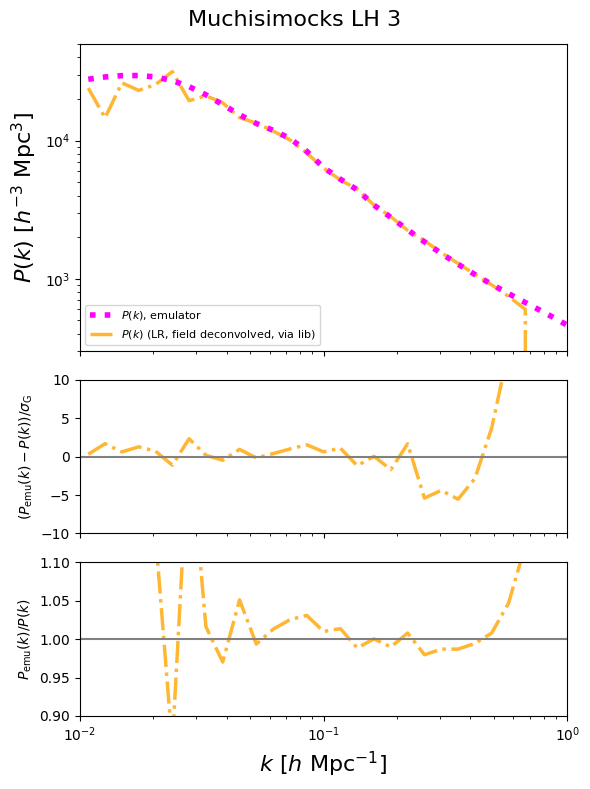

In [112]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

labels = [
          r'$P(k)$ (LR, field deconvolved, via lib)',
          r'$P(k)$ (LR, field deconvolved, via lib, z-space)',
          r'$P(k)$ (LR, field deconvolved, via lib, p(k) in z-space)',
          ]
colors = ['orange', 'cornflowerblue', 'green']
lss = ['-.', '--', '--']
lws = [2.5, 2, 1.5]
# lws = [2, 2, 1,
#        2, 2, 2, 1]
pk_objs = [pk_obj_lib,
           #pk_obj_lib_zspace,
           #pk_obj_lib_tozspace,
        #    pk_obj_mesh_deconvolveFalse,
        #    pk_obj_mesh,
        #    #pk_obj_mesh_correctgridTrue,
        #    pk_obj_mesh_hr_deconvolveFalse,
        #    pk_obj_mesh_hr
           ]
zorders = list(range(len(pk_objs),0,-1))
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

# ks.append(kk)
# pks.append(pk_nlz)
# errs.append(None)
# #errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
# labels.append(r'$P(k)$ NLz')
# colors.append('grey')
# lss.append('-')
# lws.append(1)
# zorders.append(0)

plt.suptitle(f'Muchisimocks LH {idx_LH_str}', fontsize=16)

ax.loglog(kk, pk_emu, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=4)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    if len(pk_emu)!=len(pks[i]):
        pk_interp = np.interp(kk, ks[i], pks[i])
        err_interp = np.interp(kk, ks[i], errs[i])
        ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    else:
        if errs[i] is not None:
            ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


ax1.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/\sigma_\text{G}$')
ax2.set_ylabel(r'$P_\text{emu}(k)/P(k)$')
ax.set_xlim(1e-2, 1)
ax.set_ylim(3e2, 5e4)

ax1.set_ylim(-10, 10)
ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=8, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

## Check zspace in Quijote

In [18]:
dir_quijote = '/cosmos_storage/cosmosims/Quijote_200/200/'
hvel = np.load(f'{dir_quijote}/hvel_200.npy')
hvel_fix = np.load(f'{dir_quijote}/hvel_200_fix.npy')

In [19]:
hvel.shape, hvel_fix.shape

((3, 512, 512, 512), (3, 512, 512, 512))

(512, 512, 512)
0.83032274 3940.688
0.83032274 3940.688


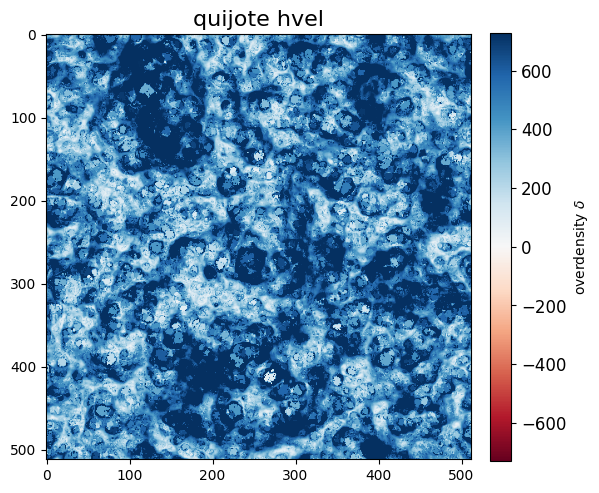

In [21]:
hvel_norm = np.linalg.norm(hvel, axis=0)
print(hvel_norm.shape)
plotter.plot_overdensity_field(hvel_norm, title=r'quijote hvel',
                               )

(512, 512, 512)
0.43909866 2107.3284
0.43909866 2107.3284


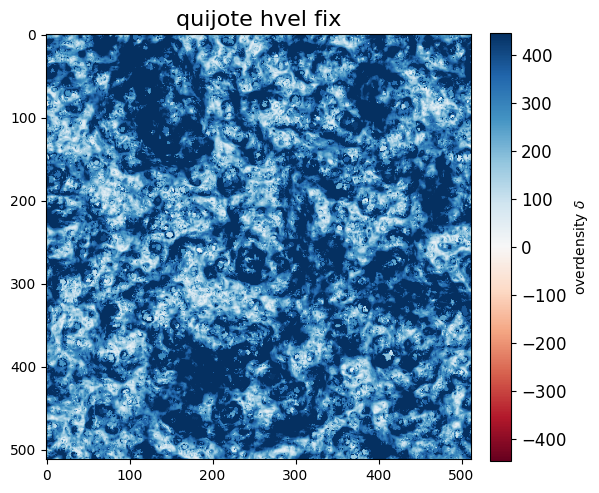

In [22]:
hvel_fix_norm = np.linalg.norm(hvel_fix, axis=0)
print(hvel_fix_norm.shape)
plotter.plot_overdensity_field(hvel_fix_norm, title=r'quijote hvel fix',
                               )

## idx 0663

In [25]:
idx_LH_str = '0663' # quijote LH idx to test
dir_mocks = '/cosmos_storage/home/mpelle/Yin_data/Quijote'
param_names = ['omega_m', 'omega_baryon', 'h', 'n_s', 'sigma_8']

n_grid = 512
box_size = 1000.0

In [69]:
fn_params = f'{dir_mocks}/LH{idx_LH_str}/param_{idx_LH_str}.txt'
param_vals = np.loadtxt(fn_params)
param_dict = dict(zip(param_names, param_vals))
cosmo_Quijote = utils.get_cosmo(param_dict)
cosmo_params_emu_quijote = utils.cosmo_bacco_to_cosmo_baccoemu(cosmo_Quijote)

In [40]:
# Quijote LH test data

fn_sim = f'{dir_mocks}/LH{idx_LH_str}/dis_{idx_LH_str}.npy'
sim_disp = np.load(fn_sim)

fn_lin = f'{dir_mocks}/LH{idx_LH_str}/lin_den_{idx_LH_str}.npy'
dens_lin = np.load(fn_lin)

fn_pos = f'{dir_mocks}/LH{idx_LH_str}/pred_pos_{idx_LH_str}.npy'
pred_disp = np.load(fn_pos)

fn_vel = f'{dir_mocks}/LH{idx_LH_str}/pred_vel_{idx_LH_str}.npy'
pred_vel = np.load(fn_vel)

In [33]:
print(pred_disp.shape, pred_vel.shape)

(3, 512, 512, 512) (3, 512, 512, 512)


In [32]:
print("Generating grid")
ngrid = 512

grid = bacco.visualization.uniform_grid(npix=ngrid, L=box_size, ndim=3, bounds=False)

print("Adding predicted displacements")
pred_pos = bacco.scaler.add_displacement(None,
                                pred_disp,
                                box=box_size,
                                pos=grid.reshape(-1,3),
                                vel=None,
                                vel_factor=0,
                                verbose=True)[0]

Generating grid


2024-07-12 15:54:35,192 bacco.scaler : Adding displacement field with a vel-factor=0.000000


Adding predicted displacements
bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [34]:
import data_creation_pipeline as datacp

In [41]:
damping_scale = 0.7 #k_nyq
interlacing = False
bmodel = bacco.BiasModel(sim=None, linear_delta=dens_lin[0], ngrid=n_grid, ngrid1=None,
                            sdm=False, mode="dm", BoxSize=box_size,
                            npart_for_fake_sim=n_grid, damping_scale=damping_scale,
                            bias_model='expansion', deposit_method="cic",
                            use_displacement_of_nn=False, interlacing=interlacing,
                            )


2024-07-12 16:02:03,592 bacco.BiasModel : Initialising Bias Model class ...


In [42]:
bias_fields = bmodel.bias_terms_lag()

2024-07-12 16:02:07,033 bacco.BiasModel : Computing delta_to_tidal_field with 4 threads...
2024-07-12 16:02:07,034 bacco.BiasModel : fttw plan
2024-07-12 16:02:07,035 bacco.BiasModel : Computing linear field ...
2024-07-12 16:02:07,036 bacco.BiasModel : Memory used: 28.935499776 Gigabytes
2024-07-12 16:02:07,039 bacco.BiasModel : fttw freqs
2024-07-12 16:02:07,040 bacco.BiasModel : tidk freqs
2024-07-12 16:02:13,604 bacco.BiasModel : ifft
2024-07-12 16:02:44,421 bacco.BiasModel : Computing laplacian ...
2024-07-12 16:02:44,423 bacco.BiasModel : Memory used: 33.767231488 Gigabytes
2024-07-12 16:02:46,664 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-07-12 16:02:46,667 bacco.BiasModel : Memory used: 34.304172032 Gigabytes
2024-07-12 16:02:47,055 bacco.BiasModel : Computing delta squared ...
2024-07-12 16:02:47,056 bacco.BiasModel : Memory used: 34.840784896 Gigabytes
2024-07-12 16:02:48,335 bacco.BiasModel : Computing tidal component G2 with the given tidal field
2

In [77]:
bias_terms_eul = []
for ii in range(0,len(bias_fields)):
    bias_terms = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pred_pos,
                            mass = (bias_fields[ii]).flatten(), deposit_method='cic',
                            interlacing=interlacing)
    bias_terms_eul.append(bias_terms)
bias_terms_eul = np.array(bias_terms_eul)
bias_terms_eul = np.squeeze(bias_terms_eul)

bias_terms_eul = datacp.deconvolve_bias_field(bias_terms_eul, n_grid)

2024-07-12 17:17:51,274 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-12 17:17:51,275 bacco.statistics : starting deposit 1
2024-07-12 17:17:55,723 bacco.statistics :  mesh done in 4.45 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-12 17:17:56,626 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-12 17:17:56,627 bacco.statistics : starting deposit 1
2024-07-12 17:18:01,479 bacco.statistics :  mesh done in 4.85 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-12 17:18:02,121 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-12 17:18:02,122 bacco.statistics : starting deposit 1
2024-07-12 17:18:06,831 bacco.statistics :  mesh done in 4.71 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-12 17:18:07,557 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-12 17:18:07,558 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb


2024-07-12 17:18:12,111 bacco.statistics :  mesh done in 4.55 s


bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-12 17:18:12,738 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-12 17:18:12,738 bacco.statistics : starting deposit 1


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb


2024-07-12 17:18:17,871 bacco.statistics :  mesh done in 5.13 s


bacco.mesh : binning of 134217728 particles (134217728 with mass)


In [78]:
bias_terms_eul_kcut = datacp.remove_lowk_modes(bias_terms_eul, box_size, ngrid_target)

now, zspace:

In [79]:
velocities = datacp.fv2bro(pred_vel.copy(order='C'))
pred_pos_zspace = bacco.statistics.compute_zsd(pred_pos, velocities, 
                                                cosmo, box_size, zspace_axis=2)

In [80]:
bias_terms_eul_zspace = []
for ii in range(0,len(bias_fields)):
    bias_terms = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pred_pos_zspace,
                            mass = (bias_fields[ii]).flatten(), deposit_method='cic',
                            interlacing=interlacing)
    bias_terms_eul_zspace.append(bias_terms)
bias_terms_eul_zspace = np.array(bias_terms_eul_zspace)
bias_terms_eul_zspace = np.squeeze(bias_terms_eul_zspace)

bias_terms_eul_zspace = datacp.deconvolve_bias_field(bias_terms_eul_zspace, n_grid)

2024-07-12 17:20:45,537 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-12 17:20:45,538 bacco.statistics : starting deposit 1
2024-07-12 17:20:49,930 bacco.statistics :  mesh done in 4.39 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-12 17:20:50,637 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-12 17:20:50,637 bacco.statistics : starting deposit 1
2024-07-12 17:20:55,002 bacco.statistics :  mesh done in 4.37 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-12 17:20:55,613 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-12 17:20:55,614 bacco.statistics : starting deposit 1
2024-07-12 17:21:00,597 bacco.statistics :  mesh done in 4.98 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-12 17:21:01,220 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-12 17:21:01,221 bacco.statistics : starting deposit 1
2024-07-12 17:21:05,863 bacco.statistics :  mesh done in 4.64 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-12 17:21:06,530 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-12 17:21:06,531 bacco.statistics : starting deposit 1
2024-07-12 17:21:11,248 bacco.statistics :  mesh done in 4.72 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=4, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


In [81]:
bias_terms_eul_kcut_zspace = datacp.remove_lowk_modes(bias_terms_eul_zspace, box_size, ngrid_target)

In [82]:
bias_vector = [0,0,0,0]

In [83]:
tracer_field = utils.get_tracer_field(bias_terms_eul, bias_vector, n_grid_norm=n_grid_orig)
tracer_field.shape

(512, 512, 512)

In [84]:
tracer_field_zspace = utils.get_tracer_field(bias_terms_eul_zspace, bias_vector, n_grid_norm=n_grid_orig)

In [85]:
tracer_field_kcut = utils.get_tracer_field(bias_terms_eul_kcut, bias_vector, n_grid_norm=n_grid_orig)

In [86]:
tracer_field_kcut_zspace = utils.get_tracer_field(bias_terms_eul_kcut_zspace, bias_vector, n_grid_norm=n_grid_orig)

In [87]:
pk_obj_quijote = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field,
                    grid2=tracer_field,
                    **args_power_grid_hr_deconvolveFalse)

2024-07-12 17:24:11,331 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.054627 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.769462 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000235 secs
bacco.power : Deallocating arrays


2024-07-12 17:24:19,249 bacco.statistics :  ...done in 7.92 s


In [88]:
pk_obj_quijote_zspace = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_zspace,
                    grid2=tracer_field_zspace,
                    **args_power_grid_hr_deconvolveFalse)

2024-07-12 17:24:20,598 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.597565 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.784019 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000329 secs
bacco.power : Deallocating arrays


2024-07-12 17:24:29,758 bacco.statistics :  ...done in 9.16 s


In [89]:
pk_obj_quijote_kcut = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_kcut,
                    grid2=tracer_field_kcut,
                    **args_power_grid_deconvolveFalse)

2024-07-12 17:24:31,134 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-07-12 17:24:31,240 bacco.statistics :  ...done in 0.106 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.012147 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.044385 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000279 secs
bacco.power : Deallocating arrays


In [90]:
pk_obj_quijote_kcut_zspace = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_kcut_zspace,
                    grid2=tracer_field_kcut_zspace,
                    **args_power_grid_deconvolveFalse)

2024-07-12 17:24:32,713 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2024-07-12 17:24:32,815 bacco.statistics :  ...done in 0.102 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.010552 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.044184 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000270 secs
bacco.power : Deallocating arrays


In [91]:
kk = pk_obj_quijote['k']

In [92]:
_, pk_emu_quijote, = emu_mpk_ext.get_nonlinear_pk(k=kk, cold=True, **cosmo_params_emu_quijote)

/tmp/ipykernel_395266/2018845693.py:42: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(ks[i], (pk_emu_quijote-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
/tmp/ipykernel_395266/2018845693.py:43: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(ks[i], (pk_emu_quijote/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


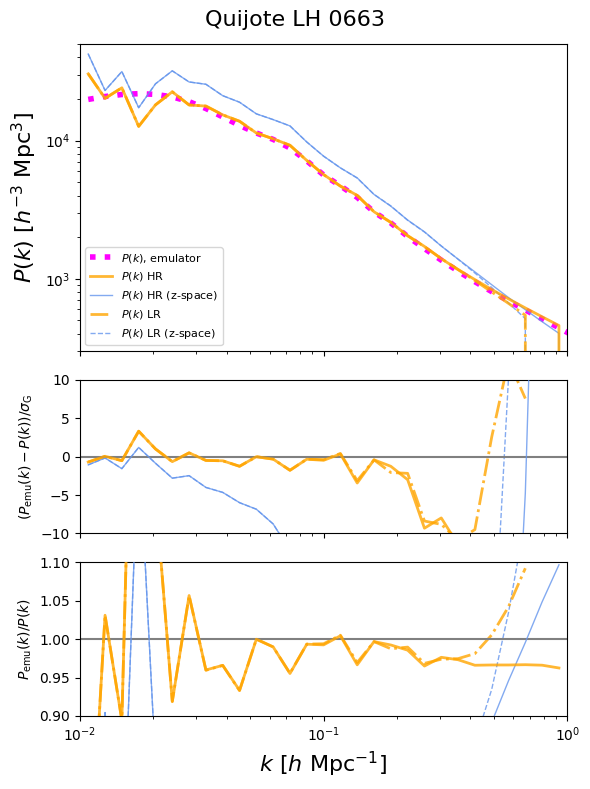

In [95]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

labels = [
          r'$P(k)$ HR',
          r'$P(k)$ HR (z-space)',
          r'$P(k)$ LR',
          r'$P(k)$ LR (z-space)',
          ]
colors = ['orange', 'cornflowerblue',
          'orange', 'cornflowerblue',]
lss = ['-', '-', '-.', '--', '--']
lws = [2, 1, 2, 1]
# lws = [2, 2, 1,
#        2, 2, 2, 1]
pk_objs = [pk_obj_quijote,
           pk_obj_quijote_zspace,
           pk_obj_quijote_kcut,
           pk_obj_quijote_kcut_zspace,
           ]
zorders = list(range(len(pk_objs),0,-1))
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

plt.suptitle(f'Quijote LH {idx_LH_str}', fontsize=16)

ax.loglog(kk, pk_emu_quijote, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=4)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    if len(pk_emu_quijote)!=len(pks[i]):
        pk_interp = np.interp(kk, ks[i], pks[i])
        err_interp = np.interp(kk, ks[i], errs[i])
        ax1.plot(kk, (pk_emu_quijote-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(kk, (pk_emu_quijote/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    else:
        if errs[i] is not None:
            ax1.plot(ks[i], (pk_emu_quijote-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(ks[i], (pk_emu_quijote/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


ax1.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/\sigma_\text{G}$')
ax2.set_ylabel(r'$P_\text{emu}(k)/P(k)$')
ax.set_xlim(1e-2, 1)
ax.set_ylim(3e2, 5e4)

ax1.set_ylim(-10, 10)
ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=8, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()